In [1]:
%reload_ext nb_black
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

print(os.getcwd())

print(os.listdir(os.getcwd()))

C:\Users\jlim7\OneDrive\Documents\GitHub\For-Fun-LoL-Data
['.git', '.gitignore', '.ipynb_checkpoints', 'Data Analysis.ipynb', 'high_diamond_ranked_10min.csv', 'Lol Blue Wins Classification.ipynb', 'Lol Data.zip', 'README.md']


<IPython.core.display.Javascript object>

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [3]:
# the data set contains stats 10 min into diamond ranked games (~10k)
# data obtained from https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min
lol = pd.read_csv("high_diamond_ranked_10min.csv")
lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


<IPython.core.display.Javascript object>

# EDA

In [4]:
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

In [5]:
### Drop all red columns, focus solely on blue side.
blue_lol = lol[lol.columns.drop(list(lol.filter(regex="red")))]
blue_lol.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0


<IPython.core.display.Javascript object>

In [6]:
# Eye balling the data, there are columns that are not necessary or redundant and can be dropped
blue_lol = blue_lol.drop(
    columns=[
        "gameId",
        "blueGoldPerMin",
        "blueGoldDiff",
        "blueCSPerMin",
        "blueAvgLevel",
        "blueExperienceDiff",
    ]
)

<IPython.core.display.Javascript object>

In [7]:
blue_lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,0,17210,17039,195,36
1,0,12,1,0,5,5,5,0,0,0,0,14712,16265,174,43
2,0,15,0,0,7,11,4,1,1,0,0,16113,16221,186,46
3,0,43,1,0,4,5,5,1,0,1,0,15157,17954,201,55
4,0,75,4,0,6,6,6,0,0,0,0,16400,18543,210,57


<IPython.core.display.Javascript object>

In [8]:
blue_lol.shape

(9879, 15)

<IPython.core.display.Javascript object>

In [9]:
# Checking for any missing values within the dataset
# There does not appear to be any missing values in the data set.
blue_lol.isna().mean()

blueWins                        0.0
blueWardsPlaced                 0.0
blueWardsDestroyed              0.0
blueFirstBlood                  0.0
blueKills                       0.0
blueDeaths                      0.0
blueAssists                     0.0
blueEliteMonsters               0.0
blueDragons                     0.0
blueHeralds                     0.0
blueTowersDestroyed             0.0
blueTotalGold                   0.0
blueTotalExperience             0.0
blueTotalMinionsKilled          0.0
blueTotalJungleMinionsKilled    0.0
dtype: float64

<IPython.core.display.Javascript object>

In [10]:
# Making sure the data is numeric
blue_lol.dtypes

blueWins                        int64
blueWardsPlaced                 int64
blueWardsDestroyed              int64
blueFirstBlood                  int64
blueKills                       int64
blueDeaths                      int64
blueAssists                     int64
blueEliteMonsters               int64
blueDragons                     int64
blueHeralds                     int64
blueTowersDestroyed             int64
blueTotalGold                   int64
blueTotalExperience             int64
blueTotalMinionsKilled          int64
blueTotalJungleMinionsKilled    int64
dtype: object

<IPython.core.display.Javascript object>

In [11]:
# This will be the target variable (what we are trying to predict)
blue_lol["blueWins"].value_counts()

0    4949
1    4930
Name: blueWins, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
blue_lol.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,0,17210,17039,195,36
1,0,12,1,0,5,5,5,0,0,0,0,14712,16265,174,43
2,0,15,0,0,7,11,4,1,1,0,0,16113,16221,186,46
3,0,43,1,0,4,5,5,1,0,1,0,15157,17954,201,55
4,0,75,4,0,6,6,6,0,0,0,0,16400,18543,210,57


<IPython.core.display.Javascript object>

In [13]:
# data is not categorical or binary, will go in num_cols
blue_lol["blueEliteMonsters"].value_counts()

0    5156
1    4013
2     710
Name: blueEliteMonsters, dtype: int64

<IPython.core.display.Javascript object>

In [14]:
# data is either yes dragon or no dragon, so will belong in the bin_cols
blue_lol["blueDragons"].value_counts()

0    6303
1    3576
Name: blueDragons, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
# data will also belong in bin_cols
blue_lol["blueHeralds"].value_counts()

0    8022
1    1857
Name: blueHeralds, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
# not enough information, I chose to only keep data from 1 and 0 tower kills, which will also place this in bin_cols
blue_lol["blueTowersDestroyed"].value_counts()

0    9415
1     429
2      27
3       7
4       1
Name: blueTowersDestroyed, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
tower_counts = blue_lol["blueTowersDestroyed"].value_counts()
keep = tower_counts[tower_counts > 400].index
blue_lol = blue_lol[blue_lol["blueTowersDestroyed"].isin(keep)]

<IPython.core.display.Javascript object>

In [18]:
blue_lol["blueTowersDestroyed"].value_counts()

0    9415
1     429
Name: blueTowersDestroyed, dtype: int64

<IPython.core.display.Javascript object>

In [19]:
# split the columns into categorical, binary, and numeric columns to be used in a pipeline
# the data does not seem to have any categorical data
num_cols = [
    "blueWardsPlaced",
    "blueWardsDestroyed",
    "blueKills",
    "blueDeaths",
    "blueAssists",
    "blueEliteMonsters",
    "blueTotalGold",
    "blueTotalExperience",
    "blueTotalMinionsKilled",
    "blueTotalJungleMinionsKilled",
]
bin_cols = [
    "blueFirstBlood",
    "blueDragons",
    "blueHeralds",
    "blueTowersDestroyed",
]

<IPython.core.display.Javascript object>

In [54]:
# split up the data so I have a target variable that I am trying to predict
X = blue_lol.drop(columns=["blueWins"])
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)

<IPython.core.display.Javascript object>

In [55]:
# set up preprocessing for pipeline (used to scale features and onehot encode if necessary)
preprocessing = ColumnTransformer(
    [("scale", StandardScaler(), num_cols),], remainder="passthrough",
)

<IPython.core.display.Javascript object>

# Random Forest Classifier (1st Trial)

In [56]:
# creating a pipeline and fitting the training data
pipeline = Pipeline(
    [("preprocessing", preprocessing), ("rf", RandomForestClassifier())]
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['blueWardsPlaced',
                                                   'blueWardsDestroyed',
                                                   'blueKills', 'blueDeaths',
                                                   'blueAssists',
                                                   'blueEliteMonsters',
                                                   'blueTotalGold',
                             

<IPython.core.display.Javascript object>

In [57]:
# Scoring the training and testing data, we see there is a big case of the model overfitting
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 1.0
Test score: 0.6871508379888268


<IPython.core.display.Javascript object>

In [68]:
y_pred = pipeline.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,676,314
Actually Win,302,677


<IPython.core.display.Javascript object>

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       990
           1       0.68      0.69      0.69       979

    accuracy                           0.69      1969
   macro avg       0.69      0.69      0.69      1969
weighted avg       0.69      0.69      0.69      1969



<IPython.core.display.Javascript object>

In [59]:
# taking a look at the vif, we see there is extremely high values for elite monsters, dragons, and heralds.
print_vif(X_train)

VIF results
-------------------------------
const                           785.274012
blueWardsPlaced                   1.011083
blueWardsDestroyed                1.026780
blueFirstBlood                    1.197845
blueKills                        13.488003
blueDeaths                        1.627682
blueAssists                       3.605759
blueEliteMonsters                      inf
blueDragons                            inf
blueHeralds                            inf
blueTowersDestroyed               1.486696
blueTotalGold                    17.887650
blueTotalExperience               4.203617
blueTotalMinionsKilled            3.067085
blueTotalJungleMinionsKilled      1.810429
dtype: float64
-------------------------------



C:\Users\jlim7\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


<IPython.core.display.Javascript object>

In [26]:
# # Getting rid of our high valued vif, I reset our x and y variables.
# X = blue_lol.drop(
#     columns=[
#         "blueWins",
#         "blueKills",
#         "blueEliteMonsters",
#         "blueDragons",
#         "blueHeralds",
#     ]
# )
# y = blue_lol["blueWins"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=13, stratify=y
# )

<IPython.core.display.Javascript object>

In [27]:
# # the new vif statement shows there are no high values to worry about so I'll run the pipeline once again
# print_vif(X_train)

<IPython.core.display.Javascript object>

In [28]:
# # Since we removed some features, we'll have to remove them from the num_cols and/or bin_cols and fix up the preprocessing
# num_cols = [
#     "blueWardsPlaced",
#     "blueWardsDestroyed",
#     "blueDeaths",
#     "blueAssists",
#     "blueTotalGold",
#     "blueTotalExperience",
#     "blueTotalMinionsKilled",
#     "blueTotalJungleMinionsKilled",
# ]
# bin_cols = [
#     "blueFirstBlood",
#     "blueTowersDestroyed",
# ]

<IPython.core.display.Javascript object>

In [29]:
# preprocessing = ColumnTransformer(
#     [("scale", StandardScaler(), num_cols),], remainder="passthrough",
# )

<IPython.core.display.Javascript object>

In [30]:
# pipeline = Pipeline(
#     [("preprocessing", preprocessing), ("rf", RandomForestClassifier())]
# )
# pipeline.fit(X_train, y_train)

<IPython.core.display.Javascript object>

In [31]:
# # Retesting the data we see there is still a lot of overfitting happening.
# train_score = pipeline.score(X_train, y_train)
# test_score = pipeline.score(X_test, y_test)

# print(f"Train score: {train_score}")
# print(f"Test score: {test_score}")

<IPython.core.display.Javascript object>

In [32]:
# the model is even less accurate than before we removed some features, so that does not seem like the best thing to do.
# y_pred = pipeline.predict(X_test)

# con_mat = pd.DataFrame(
#     confusion_matrix(y_test, y_pred),
#     index=["Actually Lose", "Actually Win"],
#     columns=["Predicted Lose", "Predicted Win"],
# )
# print(con_mat)
# print(classification_report(y_test, y_pred))

<IPython.core.display.Javascript object>

In [33]:
# Since the results seem to have gotten worse, I chose to comment out my changes.
# I will now apply a grid search to see if I can optimize my parameters

<IPython.core.display.Javascript object>

In [60]:
grid = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_depth": [2, 4, 6, 8],
    "rf__n_estimators": [50, 100, 150, 200],
}
model = GridSearchCV(pipeline, grid, cv=2, n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scale',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['blueWardsPlaced',
                                                              

<IPython.core.display.Javascript object>

In [61]:
#sorting through the grid search, it appears these are the best parameters for the model.
model.best_params_

{'rf__criterion': 'gini', 'rf__max_depth': 8, 'rf__n_estimators': 200}

<IPython.core.display.Javascript object>

In [62]:
# On the brightside, the model does not appear to be overfitting anymore
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Train score: 0.777015873015873
Test score: 0.6937531742001015


<IPython.core.display.Javascript object>

In [70]:
# the grid search seemed to help improve the scores slightly.
y_pred = model.predict(X_test)

con_mat = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win"],
    columns=["Predicted Lose", "Predicted Win"],
)
con_mat.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,685,305
Actually Win,298,681


<IPython.core.display.Javascript object>

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       990
           1       0.68      0.69      0.69       979

    accuracy                           0.69      1969
   macro avg       0.69      0.69      0.69      1969
weighted avg       0.69      0.69      0.69      1969



<IPython.core.display.Javascript object>

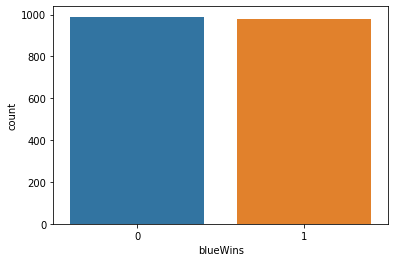

<IPython.core.display.Javascript object>

In [41]:
sns.countplot(y_test)
plt.show()

# SVC (1st Trial)

In [42]:
X = blue_lol.drop(
    columns=[
        "blueWins",
        "blueKills",
        "blueEliteMonsters",
        "blueDragons",
        "blueHeralds",
        "blueTotalGold",
    ]
)
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)

<IPython.core.display.Javascript object>

In [43]:
grid = {"C": [0.10, 1, 10, 100, 1000], "kernel": ["linear", "rbf"]}
model = GridSearchCV(SVC(), grid, cv=3, n_jobs=-1,)

<IPython.core.display.Javascript object>

In [44]:
model.fit(X_train, y_train)
model.best_params_

{'C': 10, 'kernel': 'linear'}

<IPython.core.display.Javascript object>

In [45]:
model.score(X_train, y_train)

0.7074285714285714

<IPython.core.display.Javascript object>

In [46]:
model.score(X_test, y_test)

0.6957846622651092

<IPython.core.display.Javascript object>

In [47]:
y_pred = model.predict(X_test)

<IPython.core.display.Javascript object>

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       990
           1       0.70      0.69      0.69       979

    accuracy                           0.70      1969
   macro avg       0.70      0.70      0.70      1969
weighted avg       0.70      0.70      0.70      1969



<IPython.core.display.Javascript object>

In [49]:
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win",],
    columns=["Predicted Lose", "Predicted Win",],
)

confusion_df.style.background_gradient(axis=None)

,Predicted Lose,Predicted Win
Actually Lose,696,294
Actually Win,305,674


<IPython.core.display.Javascript object>

# Logistic Regression (1st Trial)

In [50]:
X = blue_lol.drop(
    columns=[
        "blueWins",
        "blueKills",
        "blueEliteMonsters",
        "blueDragons",
        "blueHeralds",
        "blueTotalGold",
    ]
)
y = blue_lol["blueWins"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=13, stratify=y
)

<IPython.core.display.Javascript object>

In [51]:
grid = {"penalty": ["l1", "l2", "elasticnet", "none"], "solver": ["lbfgs", "liblinear"]}
model = GridSearchCV(LogisticRegression(), grid, cv=3, n_jobs=-1,)

NameError: name 'LogisticRegression' is not defined

<IPython.core.display.Javascript object>

In [ ]:
model.fit(X_train, y_train)

In [ ]:
model.best_params_

In [ ]:
model.score(X_train, y_train)

In [ ]:
model.score(X_test, y_test)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["Actually Lose", "Actually Win",],
    columns=["Predicted Lose", "Predicted Win",],
)

confusion_df.style.background_gradient(axis=None)